<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 21, '日付': '2021-10-28T08:00:00.000Z'},
 {'小計': 24, '日付': '2021-10-29T08:00:00.000Z'},
 {'小計': 23, '日付': '2021-10-30T08:00:00.000Z'},
 {'小計': 22, '日付': '2021-10-31T08:00:00.000Z'},
 {'小計': 9, '日付': '2021-11-01T08:00:00.000Z'},
 {'小計': 18, '日付': '2021-11-02T08:00:00.000Z'},
 {'小計': 25, '日付': '2021-11-03T08:00:00.000Z'},
 {'小計': 14, '日付': '2021-11-04T08:00:00.000Z'},
 {'小計': 25, '日付': '2021-11-05T08:00:00.000Z'},
 {'小計': 29, '日付': '2021-11-06T08:00:00.000Z'},
 {'小計': 21, '日付': '2021-11-07T08:00:00.000Z'},
 {'小計': 18, '日付': '2021-11-08T08:00:00.000Z'},
 {'小計': 30, '日付': '2021-11-09T08:00:00.000Z'},
 {'小計': 25, '日付': '2021-11-10T08:00:00.000Z'},
 {'小計': 31, '日付': '2021-11-11T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-11-07 17:00:00+09:00,81,0,21,2021-11-07 17:00:00+09:00
2021-11-08 17:00:00+09:00,105,0,18,2021-11-08 17:00:00+09:00
2021-11-09 17:00:00+09:00,105,0,30,2021-11-09 17:00:00+09:00
2021-11-10 17:00:00+09:00,100,0,25,2021-11-10 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-11-07 17:00:00+09:00,81,0,21,2021-11-07 17:00:00+09:00,94.428571,661.0,0.0,0.0,20.142857,141.0
2021-11-08 17:00:00+09:00,105,0,18,2021-11-08 17:00:00+09:00,94.285714,660.0,0.0,0.0,21.428571,150.0
2021-11-09 17:00:00+09:00,105,0,30,2021-11-09 17:00:00+09:00,95.285714,667.0,0.0,0.0,23.142857,162.0
2021-11-10 17:00:00+09:00,100,0,25,2021-11-10 17:00:00+09:00,97.857143,685.0,0.0,0.0,23.142857,162.0
2021-11-11 17:00:00+09:00,0,0,31,2021-11-11 17:00:00+09:00,83.285714,583.0,0.0,0.0,25.571429,179.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-10-28 17:00:00+09:00,102,0,21,2021-10-28 17:00:00+09:00,96.285714,674.0,0.0,0.0,25.714286,180.0,'21w43,Thu
2021-10-29 17:00:00+09:00,92,0,24,2021-10-29 17:00:00+09:00,94.714286,663.0,0.0,0.0,25.428571,178.0,'21w43,Fri
2021-10-30 17:00:00+09:00,88,0,23,2021-10-30 17:00:00+09:00,98.428571,689.0,0.0,0.0,24.142857,169.0,'21w43,Sat
2021-10-31 17:00:00+09:00,77,0,22,2021-10-31 17:00:00+09:00,98.857143,692.0,0.0,0.0,24.571429,172.0,'21w43,Sun
2021-11-01 17:00:00+09:00,106,0,9,2021-11-01 17:00:00+09:00,93.571429,655.0,0.0,0.0,23.428571,164.0,'21w44,Mon
2021-11-02 17:00:00+09:00,98,0,18,2021-11-02 17:00:00+09:00,92.714286,649.0,0.0,0.0,21.857143,153.0,'21w44,Tue
2021-11-03 17:00:00+09:00,82,0,25,2021-11-03 17:00:00+09:00,92.142857,645.0,0.0,0.0,20.285714,142.0,'21w44,Wed
2021-11-04 17:00:00+09:00,102,0,14,2021-11-04 17:00:00+09:00,92.142857,645.0,0.0,0.0,19.285714,135.0,'21w44,Thu
2021-11-05 17:00:00+09:00,92,0,25,2021-11-05 17:00:00+09:00,92.142857,645.0,0.0,0.0,19.428571,136.0,'21w44,Fri
2021-11-06 17:00:00+09:00,100,0,29,2021-11-06 17:00:00+09:00,93.857143,657.0,0.0,0.0,20.285714,142.0,'21w44,Sat


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-10-24 17:00:00+09:00,31.285714,219
2021-10-31 17:00:00+09:00,24.571429,172
2021-11-07 17:00:00+09:00,20.142857,141
2021-11-11 17:00:00+09:00,26.000000,104
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-10-28 17:00:00+09:00,102,0,21,2021-10-28 17:00:00+09:00,96.285714,674.0,0.0,0.0,25.714286,180.0,'21w43,Thu,NaN,NaN
2021-10-29 17:00:00+09:00,92,0,24,2021-10-29 17:00:00+09:00,94.714286,663.0,0.0,0.0,25.428571,178.0,'21w43,Fri,NaN,NaN
2021-10-30 17:00:00+09:00,88,0,23,2021-10-30 17:00:00+09:00,98.428571,689.0,0.0,0.0,24.142857,169.0,'21w43,Sat,NaN,NaN
2021-10-31 17:00:00+09:00,77,0,22,2021-10-31 17:00:00+09:00,98.857143,692.0,0.0,0.0,24.571429,172.0,'21w43,Sun,24.571429,172.0
2021-11-01 17:00:00+09:00,106,0,9,2021-11-01 17:00:00+09:00,93.571429,655.0,0.0,0.0,23.428571,164.0,'21w44,Mon,NaN,NaN
2021-11-02 17:00:00+09:00,98,0,18,2021-11-02 17:00:00+09:00,92.714286,649.0,0.0,0.0,21.857143,153.0,'21w44,Tue,NaN,NaN
2021-11-03 17:00:00+09:00,82,0,25,2021-11-03 17:00:00+09:00,92.142857,645.0,0.0,0.0,20.285714,142.0,'21w44,Wed,NaN,NaN
2021-11-04 17:00:00+09:00,102,0,14,2021-11-04 17:00:00+09:00,92.142857,645.0,0.0,0.0,19.285714,135.0,'21w44,Thu,NaN,NaN
2021-11-05 17:00:00+09:00,92,0,25,2021-11-05 17:00:00+09:00,92.142857,645.0,0.0,0.0,19.428571,136.0,'21w44,Fri,NaN,NaN
2021-11-06 17:00:00+09:00,100,0,29,2021-11-06 17:00:00+09:00,93.857143,657.0,0.0,0.0,20.285714,142.0,'21w44,Sat,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

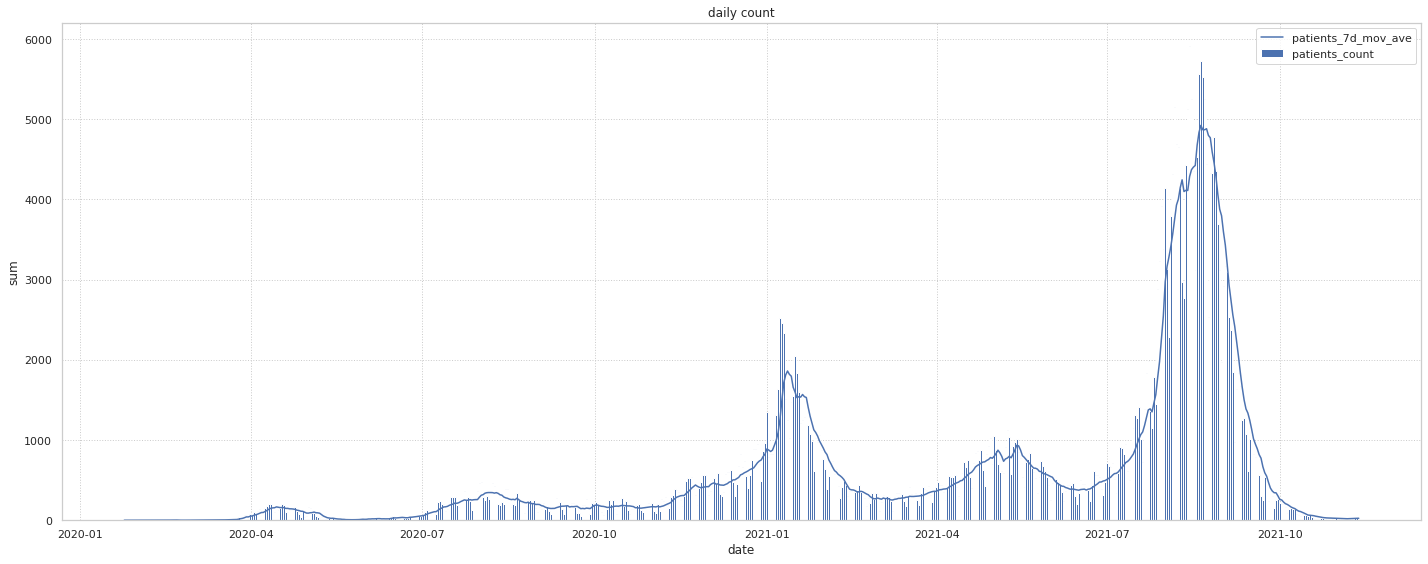

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
643,1.635408e+09,2021,10,28,0,0,0,0,1,0,0,643,0,569,102,96.285714,674.0,0,0.0,0.0,21,25.714286,180.0
644,1.635494e+09,2021,10,29,1,0,0,0,0,0,0,644,0,570,92,94.714286,663.0,0,0.0,0.0,24,25.428571,178.0
645,1.635581e+09,2021,10,30,0,0,1,0,0,0,0,645,0,571,88,98.428571,689.0,0,0.0,0.0,23,24.142857,169.0
646,1.635667e+09,2021,10,31,0,0,0,1,0,0,0,646,0,572,77,98.857143,692.0,0,0.0,0.0,22,24.571429,172.0
647,1.635754e+09,2021,11,1,0,1,0,0,0,0,0,647,0,573,106,93.571429,655.0,0,0.0,0.0,9,23.428571,164.0
648,1.635840e+09,2021,11,2,0,0,0,0,0,1,0,648,0,574,98,92.714286,649.0,0,0.0,0.0,18,21.857143,153.0
649,1.635926e+09,2021,11,3,0,0,0,0,0,0,1,649,0,575,82,92.142857,645.0,0,0.0,0.0,25,20.285714,142.0
650,1.636013e+09,2021,11,4,0,0,0,0,1,0,0,650,0,576,102,92.142857,645.0,0,0.0,0.0,14,19.285714,135.0
651,1.636099e+09,2021,11,5,1,0,0,0,0,0,0,651,0,577,92,92.142857,645.0,0,0.0,0.0,25,19.428571,136.0
652,1.636186e+09,2021,11,6,0,0,1,0,0,0,0,652,0,578,100,93.857143,657.0,0,0.0,0.0,29,20.285714,142.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            658 non-null    float64
 1   year                 658 non-null    int64  
 2   month                658 non-null    int64  
 3   day                  658 non-null    int64  
 4   Fri                  658 non-null    uint8  
 5   Mon                  658 non-null    uint8  
 6   Sat                  658 non-null    uint8  
 7   Sun                  658 non-null    uint8  
 8   Thu                  658 non-null    uint8  
 9   Tue                  658 non-null    uint8  
 10  Wed                  658 non-null    uint8  
 11  passed               658 non-null    int64  
 12  emergency            658 non-null    int64  
 13  em_passed            658 non-null    int64  
 14  contacts_count       658 non-null    int64  
 15  contacts_7d_mov_ave  658 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.580000e+02,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000
mean,1.608235e+09,2020.478723,6.325228,15.705167,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,328.500000,0.074468,258.717325,656.302432,655.978253,4591.841945,560.059271,560.059271,3920.414894,580.395137,580.277964,4061.920973
std,1.642399e+07,0.499927,3.183959,8.874810,0.350193,0.350193,0.350193,0.350193,0.350193,0.350193,0.350193,190.092521,0.262731,183.732655,470.317793,458.360524,3208.531973,821.321374,749.571474,5247.000321,978.829910,945.897180,6621.295465
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.594044e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,164.250000,0.000000,90.250000,344.000000,351.428571,2460.000000,0.000000,0.000000,0.000000,76.250000,93.142857,652.000000
50%,1.608235e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,328.500000,0.000000,254.500000,511.000000,517.642857,3623.500000,0.000000,0.000000,0.000000,258.000000,269.285714,1885.000000
75%,1.622426e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,492.750000,0.000000,418.750000,786.500000,775.250000,5426.750000,1152.000000,1142.928571,8000.500000,582.250000,598.000000,4186.000000
max,1.636618e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,657.000000,1.000000,583.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5908.000000,4923.428571,34464.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,8.652420e-01,0.332352,-0.008840,-6.447790e-03,-6.900907e-18,-4.298526e-03,-2.149263e-03,6.447790e-03,2.149263e-03,4.298526e-03,1.000000e+00,-3.442116e-01,0.997831,-0.210814,-0.194921,-0.194918,-0.608255,-6.546681e-01,-6.546681e-01,0.456630,0.481998,0.482003
year,8.652420e-01,1.000000e+00,-0.183066,-0.035722,-4.802014e-17,-4.705491e-17,-4.753752e-17,-4.705491e-17,-4.729622e-17,-4.705491e-17,-4.717556e-17,8.652420e-01,-2.718301e-01,0.873179,-0.206686,-0.188776,-0.188774,-0.653972,-7.165713e-01,-7.165713e-01,0.431615,0.455813,0.455815
month,3.323524e-01,-1.830664e-01,1.000000,-0.041363,-1.306580e-02,5.850359e-04,-8.970550e-03,-4.875299e-03,1.287079e-02,4.680287e-03,8.775538e-03,3.323524e-01,-1.618209e-01,0.313044,-0.022754,-0.025396,-0.025392,0.038827,6.677145e-02,6.677145e-02,0.081505,0.085766,0.085772
day,-8.839912e-03,-3.572193e-02,-0.041363,1.000000,4.757498e-03,-6.016835e-03,5.736982e-03,7.206210e-03,-2.588638e-03,-5.037350e-03,-4.057866e-03,-8.839912e-03,-3.611104e-04,-0.008246,-0.002304,-0.003035,-0.003037,0.009845,-1.587586e-03,-1.587586e-03,0.012710,0.009640,0.009636
Fri,-6.447790e-03,-4.802014e-17,-0.013066,0.004757,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-6.447790e-03,3.231353e-17,-0.005900,-0.014578,-0.000376,-0.000375,0.028875,6.262497e-18,-1.883458e-18,0.029892,-0.000047,-0.000049
Mon,-6.900907e-18,-4.705491e-17,0.000585,-0.006017,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,2.924317e-18,2.175280e-17,-0.000010,0.034448,0.000011,0.000012,0.114170,8.569733e-18,-7.533831e-19,-0.091530,-0.000005,-0.000004
Sat,-4.298526e-03,-4.753752e-17,-0.008971,0.005737,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-4.298526e-03,2.175280e-17,-0.003937,0.046249,-0.000241,-0.000240,-0.131788,9.228943e-18,1.506766e-18,0.030585,-0.000028,-0.000030
Sun,-2.149263e-03,-4.705491e-17,-0.004875,0.007206,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-2.149263e-03,2.175280e-17,-0.001974,-0.024022,-0.000131,-0.000130,-0.121421,2.636841e-18,0.000000e+00,-0.022802,-0.000016,-0.000016
Thu,6.447790e-03,-4.729622e-17,0.012871,-0.002589,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,6.447790e-03,1.216779e-17,0.005928,-0.007647,0.000289,0.000290,0.033310,-1.977631e-18,3.013532e-18,0.051641,0.000051,0.000052
Tue,2.149263e-03,-4.705491e-17,0.004680,-0.005037,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,2.149263e-03,2.267113e-17,0.001953,-0.020843,0.000153,0.000154,0.045550,3.625656e-18,-4.520299e-18,-0.019383,0.000014,0.000015


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,1.636272e+09,0,0,0,1,0,0,0,653,0,579,81,0,21,20.142857,141.0
654,1.636358e+09,0,1,0,0,0,0,0,654,0,580,105,0,18,21.428571,150.0
655,1.636445e+09,0,0,0,0,0,1,0,655,0,581,105,0,30,23.142857,162.0
656,1.636531e+09,0,0,0,0,0,0,1,656,0,582,100,0,25,23.142857,162.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
653,1.636272e+09,653,0,21,20.142857,141.0
654,1.636358e+09,654,0,18,21.428571,150.0
655,1.636445e+09,655,0,30,23.142857,162.0
656,1.636531e+09,656,0,25,23.142857,162.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

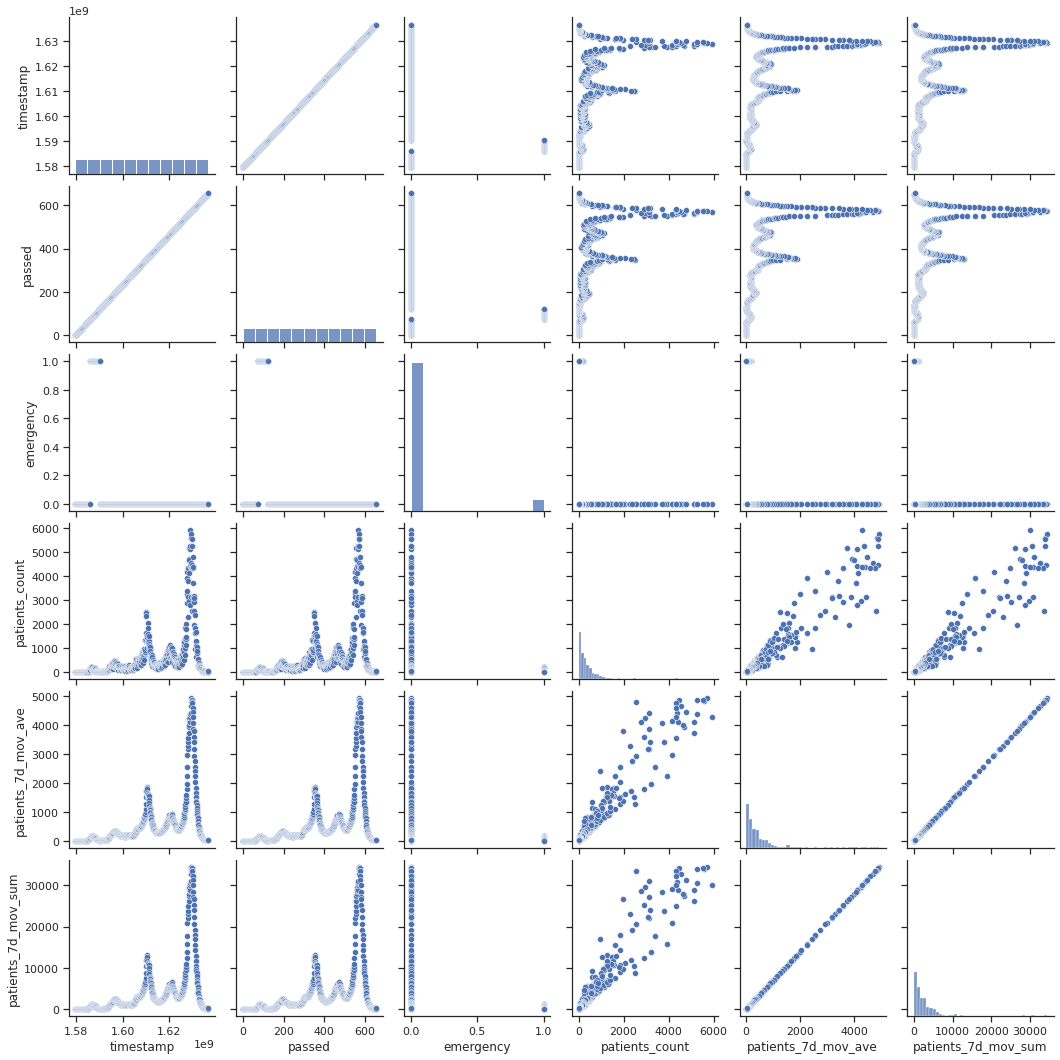

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
